In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
from tqdm import tqdm
import random
from random import shuffle

In [2]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data, figsize=(16,8), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.imshow(convert_to_rgb(data.astype(int)))
    plt.title(title)
    plt.show()

def convert_to_rgb(img):
    img = deepcopy(img)
    b,g,r = cv2.split(img)  
    img = cv2.merge([r,g,b])
    return img

In [3]:
file_num = 90
frame_dir = f'../scene_data/{file_num}'
frame_bt_dir = f'../scene_data/{file_num}_back_true'

In [4]:
scene_dict = {}
for file_name in os.listdir(frame_dir):
    if file_name[0] != '.':
        num, verti_pos, hori_pos, real_back_prob = file_name.replace('.jpg', '').split('_')
        scene_dict[int(num)] = {'file_name': file_name, 'num':num, 'verti_pos':int(verti_pos), 'hori_pos':int(hori_pos)}

In [5]:
scene_bt_dict = {}
for file_name in os.listdir(frame_bt_dir):
    if file_name[0] != '.':
        num, verti_pos, hori_pos, real_back_prob = file_name.replace('.npy', '').split('_')
        scene_bt_dict[int(num)] = {'file_name': file_name, 'num':num, 'verti_pos':int(verti_pos), 'hori_pos':int(hori_pos)}

In [6]:
scene_num_0 = random.choice(sorted(list(scene_dict.keys()))[5:-5])
file_name_0 = scene_dict[scene_num_0]['file_name']
file_name_bt_0 = scene_bt_dict[scene_num_0]['file_name']
frame_0 = cv2.imread(f"{frame_dir}/{file_name_0}")
frame_bt_0 = np.load(f"{frame_bt_dir}/{file_name_bt_0}").astype(int)

n = 1

set_shape = (n*2, n*2, 3)

compare_frame_dict = {}

for i in range(-5,6):
    if i == 0:
        continue
    m_num = 3 + 4 * abs(i)
    compare_frame_dict[i] = {}
    scene_num = scene_num_0 + i
    file_name = scene_dict[scene_num]['file_name']
    file_name_bt = scene_bt_dict[scene_num]['file_name']
    
    abs_pos_0 = np.array((scene_dict[scene_num_0]['verti_pos'], scene_dict[scene_num_0]['hori_pos']))
    abs_pos_1 = np.array((scene_dict[scene_num]['verti_pos'], scene_dict[scene_num]['hori_pos']))
    
    frame_1 = cv2.imread(f"{frame_dir}/{file_name}")
    frame_bt_1 = np.load(f"{frame_bt_dir}/{file_name_bt}").astype(int)
    compare_frame_dict[i]['euclidean_dis'] = np.sqrt(np.sum(np.power(abs_pos_1 - abs_pos_0, 2)/2))
    
    compare_dict = {}
    for s0 in tqdm(range(n, frame_0.shape[0]), ncols=70):
        for s1 in range(n, frame_0.shape[1]):
            segment_0 = frame_0[s0-n:s0+n, s1-n:s1+n, :]
            if segment_0.shape == set_shape:
                temp_compare = {}
                for m1 in range(-m_num, m_num+1):
                    for m2 in range(-m_num, m_num+1):
                        compare_1 = frame_1[max(s0-n+m1,0):max(s0+n+m1,0), max(s1-n+m2,0):max(s1+n+m2,0), :]
                        if compare_1.shape == set_shape:
                            diff_array = segment_0 - compare_1
                            diff = np.sum(np.power(diff_array,2))/len(diff_array)
                            temp_compare[(m1,m2)] = diff
                temp_compare = {k: v for k, v in sorted(temp_compare.items(), key=lambda item: item[1])}
                compare_dict[(s0,s1)] = np.array(list(temp_compare.keys())[0])

    compare_mean_dict = {}
    for key in tqdm(compare_dict, ncols=70):
        compare_mean_dict[key] = []
        s0, s1 = key
        for c0 in range(s0-n,s0+n):
            for c1 in range(s1-n, s1+n):
                if (c0, c1) in compare_dict:
                    compare_mean_dict[key].append(compare_dict[(c0, c1)])
    compare_frame_dict[i]['compare_mean_dict'] = compare_mean_dict

100%|█████████████████████| 398701/398701 [00:01<00:00, 283884.19it/s]


In [7]:
np.save(f'{file_num}_hedge_back.npy', compare_frame_dict)
np.save(f'{file_num}_hedge_back_frame_bt_0.npy', frame_bt_0)

In [8]:
for i in compare_frame_dict:
    compare_mean_dict = compare_frame_dict[i]['compare_mean_dict']
    euclidean_dis = compare_frame_dict[i]['euclidean_dis']
    
    for key in tqdm(compare_mean_dict, ncols=70):
        compare_mean_dict[key] = np.mean(compare_mean_dict[key], axis=0)
        compare_mean_dict[key] = np.sqrt(np.sum(np.power(compare_mean_dict[key], 2)/2))

100%|██████████████████████| 398701/398701 [00:12<00:00, 31874.68it/s]


In [32]:
for i in tqdm(compare_frame_dict):
    compare_mean_dict = compare_frame_dict[i]['compare_mean_dict']
    euclidean_dis = compare_frame_dict[i]['euclidean_dis']
    
    sorted_compare_mean_dict = {k: v for k, v in sorted(compare_mean_dict.items(), key=lambda item: item[1])}
    
    back_keys = list(sorted_compare_mean_dict.keys())[:int(len(sorted_compare_mean_dict)*0.86)]
    hedge_keys = list(sorted_compare_mean_dict.keys())[int(len(sorted_compare_mean_dict)*0.86):]
    
    back_compare_mean_dict = {k: compare_mean_dict[k] for k in back_keys}
    hedge_compare_mean_dict = {k: compare_mean_dict[k] for k in hedge_keys}
    
    compare_frame_dict[i]['back'] = back_compare_mean_dict
    compare_frame_dict[i]['hedge'] = hedge_compare_mean_dict

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


In [29]:
# i = -1

In [30]:
# compare_frame_dict[i]['back']

back_accuracy 0.8871040182920071 342882
hedge_accuracy 0.25734964796932946 55819
back_accuracy 0.8969048459547952 308773
hedge_accuracy 0.31501612160294795 21710
back_accuracy 0.9173126707638027 278894
hedge_accuracy 0.42001777382803823 9002
back_accuracy 0.9209667367765054 256740
hedge_accuracy 0.5569242996224916 5033
back_accuracy 0.9366098712647 235289
hedge_accuracy 0.7568117120780805 2459
back_accuracy 0.9405490623959759 216296
hedge_accuracy 0.9331698344573881 1631
back_accuracy 0.9432583842429466 197245
hedge_accuracy 0.958656330749354 774
back_accuracy 0.9489771533686416 179939
hedge_accuracy 0.9562043795620438 411
back_accuracy 0.9501972565058453 165774
hedge_accuracy 0.9825174825174825 286
back_accuracy 0.952120824697002 154869
hedge_accuracy 0.9896907216494846 194


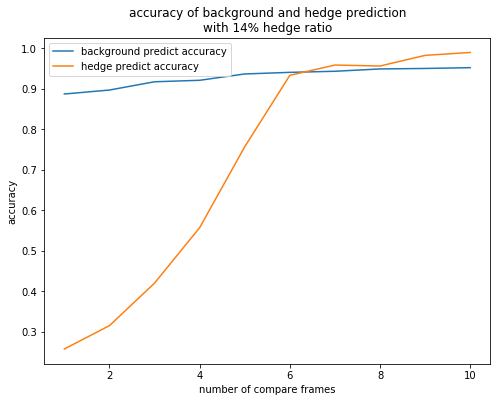

In [35]:
back_compare_mean_dict = {}
hedge_compare_mean_dict = {}
back_acc_list = []
back_count_list = []
hedge_acc_list = []
hedge_count_list = []
for i in compare_frame_dict:
    if len(back_compare_mean_dict):
        back_compare_mean_dict = {k:v for k, v in back_compare_mean_dict.items() if k in compare_frame_dict[i]['back']}
    else:
        back_compare_mean_dict = compare_frame_dict[i]['back']
        
    if len(hedge_compare_mean_dict):
        hedge_compare_mean_dict = {k:v for k, v in hedge_compare_mean_dict.items() if k in compare_frame_dict[i]['hedge']}
    else:
        hedge_compare_mean_dict = compare_frame_dict[i]['hedge']
    
    back_accurate_list = []
    for i, j in back_compare_mean_dict:
        if sum(frame_bt_0[i][j])==3:
            back_accurate_list.append(1)
        else:
            back_accurate_list.append(0)
    print('back_accuracy', sum(back_accurate_list)/len(back_accurate_list), len(back_accurate_list))
    back_acc_list.append(sum(back_accurate_list)/len(back_accurate_list))
    back_count_list.append(len(back_accurate_list))
    hedge_accurate_list = []
    for i, j in hedge_compare_mean_dict:
        if sum(frame_bt_0[i][j]) == 0:
            hedge_accurate_list.append(1)
        else:
            hedge_accurate_list.append(0)
    hedge_acc_list.append(sum(hedge_accurate_list)/len(hedge_accurate_list))
    hedge_count_list.append(len(hedge_accurate_list))
    print('hedge_accuracy', sum(hedge_accurate_list)/len(hedge_accurate_list), len(hedge_accurate_list))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(list(range(1,11)), back_acc_list)
plt.plot(list(range(1,11)), hedge_acc_list)
plt.title('accuracy of background and hedge prediction\nwith 14% hedge ratio')
plt.legend(['background predict accuracy', 'hedge predict accuracy'])
plt.ylabel('accuracy')
plt.xlabel('number of compare frames')
plt.savefig('back_hedge_14.png')

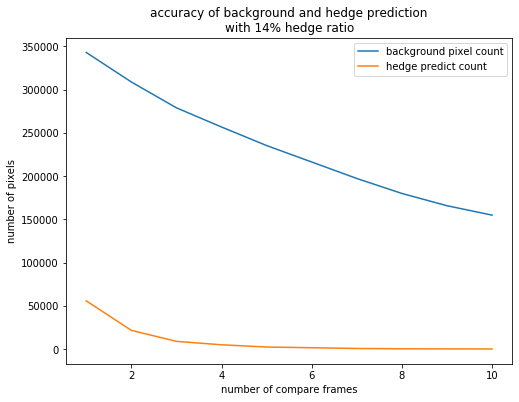

In [36]:
back_compare_mean_dict = {}
hedge_compare_mean_dict = {}
back_acc_list = []
back_count_list = []
hedge_acc_list = []
hedge_count_list = []
for i in compare_frame_dict:
    if len(back_compare_mean_dict):
        back_compare_mean_dict = {k:v for k, v in back_compare_mean_dict.items() if k in compare_frame_dict[i]['back']}
    else:
        back_compare_mean_dict = compare_frame_dict[i]['back']
        
    if len(hedge_compare_mean_dict):
        hedge_compare_mean_dict = {k:v for k, v in hedge_compare_mean_dict.items() if k in compare_frame_dict[i]['hedge']}
    else:
        hedge_compare_mean_dict = compare_frame_dict[i]['hedge']
    
    back_accurate_list = []
    for i, j in back_compare_mean_dict:
        if sum(frame_bt_0[i][j])==3:
            back_accurate_list.append(1)
        else:
            back_accurate_list.append(0)
#     print('back_accuracy', sum(back_accurate_list)/len(back_accurate_list), len(back_accurate_list))
    back_acc_list.append(sum(back_accurate_list)/len(back_accurate_list))
    back_count_list.append(len(back_accurate_list))
    hedge_accurate_list = []
    for i, j in hedge_compare_mean_dict:
        if sum(frame_bt_0[i][j]) == 0:
            hedge_accurate_list.append(1)
        else:
            hedge_accurate_list.append(0)
    hedge_acc_list.append(sum(hedge_accurate_list)/len(hedge_accurate_list))
    hedge_count_list.append(len(hedge_accurate_list))
#     print('hedge_accuracy', sum(hedge_accurate_list)/len(hedge_accurate_list), len(hedge_accurate_list))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(list(range(1,11)), back_count_list)
plt.plot(list(range(1,11)), hedge_count_list)
plt.title('accuracy of background and hedge prediction\nwith 14% hedge ratio')
plt.legend(['background pixel count', 'hedge predict count'])
plt.ylabel('number of pixels')
plt.xlabel('number of compare frames')
plt.savefig('back_hedge_14_count.png')

In [13]:
# i = 2

In [14]:
# back_compare_mean_dict = compare_frame_dict[i]['back']
# hedge_compare_mean_dict = compare_frame_dict[i]['hedge']

In [15]:
for i in range(-3,4):
    if i == 0:
        continue
    back_compare_mean_dict = compare_frame_dict[i]['back']
    back_accurate_list = []
    for i, j in back_compare_mean_dict:
        if sum(frame_bt_1[i][j])==3:
            back_accurate_list.append(1)
        else:
            back_accurate_list.append(0)
    print(sum(back_accurate_list)/len(back_accurate_list))

0.8636211216856378
0.8632779483668033
0.8649305758978265
0.866053710808308
0.8684100278686833
0.8763915221143779


In [16]:
for i in range(-3,4):
    if i == 0:
        continue
    hedge_compare_mean_dict = compare_frame_dict[i]['hedge']
    hedge_accurate_list = []
    for i, j in hedge_compare_mean_dict:
        if sum(frame_bt_1[i][j]) == 0:
            hedge_accurate_list.append(1)
        else:
            hedge_accurate_list.append(0)
    print(sum(hedge_accurate_list)/len(hedge_accurate_list))

0.13229504005454235
0.13155024153904998
0.13340504827407315
0.13399000148492798
0.13565384615384615
0.14222588578687062


In [17]:
back_accurate_list = []
for i, j in back_compare_mean_dict:
    if sum(frame_bt_1[i][j])==3:
        back_accurate_list.append(1)
    else:
        back_accurate_list.append(0)
print(sum(back_accurate_list)/len(back_accurate_list))

0.8763915221143779


In [18]:
hedge_accurate_list = []
for i, j in hedge_compare_mean_dict:
    if sum(frame_bt_1[i][j]) == 0:
        hedge_accurate_list.append(1)
    else:
        hedge_accurate_list.append(0)
print(sum(hedge_accurate_list)/len(hedge_accurate_list))

0.14222588578687062


In [19]:
len(back_accurate_list), len(hedge_accurate_list)

(176695, 222006)